# CSCM72 Coursework 1: Python Optimisers

Name: Neil Woodhouse<br>
Student Number: 851182

# Section 1: Function Implementation & Testing

In [260]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import truncnorm

In [261]:
# Constants to improve readability
HEIGHT = 0     #x1
LENGTH = 1     #x2
THICKNESS = 2  #x3
BREADTH = 3    #x4

# Store the default upper and lower bound for x1..x4 as defined in the specification
DEFAULT_LOWER = np.array([0.125, 0.125, 0.1, 0.1])
DEFAULT_UPPER = np.array([5.0, 5.0, 10.0, 10.0])

## Constraint Function Execution Tracking
The number of executions of each constraint function is tracked with a global variable. 
A function is included that prints the state of all these variables, to make checking them easier. 

In [262]:
# Counter Variables to track the number of time Constraint Functions have been executed
f_counter = 0
g1_counter = 0
g2_counter = 0
g3_counter = 0
g4_counter = 0

# Prints how many times each constraint function has been executed
def print_execution_trackers():
    global f_counter
    global g1_counter
    global g2_counter
    global g3_counter
    global g4_counter
    print(
        "Constraint function Execution counts: \nf: {}, g1: {}, g2: {}, g3: {}, g4: {}".format(f_counter, g1_counter, g2_counter, g3_counter, g4_counter)
    )

## Function Implementations

This subsection defines the function implementations for the objective function and each of the constraint functions. 

### Objective Function *f(x)*:

In [263]:
def objective_calc(design):
    global f_counter
    f_counter += 1
    return ( 1.10471 * (design[HEIGHT] ** 2) * design[LENGTH]) + (0.04811 * design[THICKNESS] * design[BREADTH] * (14.0 + design[LENGTH]) )

### Shear Stress *g<sub>1</sub>(x)*:

In [264]:
def shear_stress(design):
    # Calculates the first derivative
    tau1 = 6000 / (math.sqrt(2) * design[HEIGHT] * design[LENGTH])

    # Calculates the second derivative
    tau2 = (6000 * (14 + 0.5 * design[LENGTH]) * math.sqrt(0.25 * (design[LENGTH]**2 + (design[HEIGHT] + design[THICKNESS])**2 ) ) )  \
                        / ( 2 * (0.707 * design[HEIGHT] * design[LENGTH] * ( ( (design[LENGTH] ** 2) / 12) + 0.25 * (design[HEIGHT] + design[THICKNESS])**2 ) ) )
    
    # Calculates the overall shear stress of the design
    tau = math.sqrt( (tau1**2 + tau2**2) + ( (design[LENGTH] * tau1 * tau2) \
           / (math.sqrt(0.25*(design[LENGTH]**2 + (design[HEIGHT] + design[THICKNESS])**2))) ))

    global g1_counter
    g1_counter += 1
    return 13600 - tau

### Normal Stress *g<sub>2</sub>(x)*:

In [265]:
def normal_stress(design):
    # Calculates normal stress of the design
    sigma = 504000 / (design[THICKNESS]**2 * design[BREADTH])

    global g2_counter
    g2_counter += 1
    return (30000 - sigma)

### Practicality *g<sub>3</sub>(x)*:

In [266]:
def practicality(design):
    global g3_counter
    g3_counter += 1
    return (design[BREADTH] - design[HEIGHT])

### Buckling Load *g<sub>4</sub>(x)*:

In [267]:
def buckling_load(design):
    rho = 64746.022 * (1 - 0.0282346 * design[THICKNESS]) * design[THICKNESS] * design[BREADTH]**3

    global g4_counter
    g4_counter += 1
    return (rho - 6000)

## Function Validation:

This section checks the validity of the constraint functions, using the example input design from the specification.

In [268]:
x = np.array([1.05, 3.15, 4.43, 7.87])

print("Objective Function Output: ", objective_calc(x))
print("First constraint function output: ", shear_stress(x))
print("Second constraint function output: ", normal_stress(x))
print("Third constraint function output: ", practicality(x))
print("Fourth constraint function output: ", buckling_load(x))

Objective Function Output:  32.6024179859
First constraint function output:  5308.848564674312
Second constraint function output:  26736.764990548952
Third constraint function output:  6.82
Fourth constraint function output:  122317448.61430933


In [269]:
print_execution_trackers()

Constraint function Execution counts: 
f: 1, g1: 1, g2: 1, g3: 1, g4: 1


# Section 2: Random Search

This code defines a flexible random search that takes a system of any 4 parameters and 4 constraint functions and returns a system design that approximately minimises the objective value.

In [270]:
# This function performs random search optimisation using a given seed for number generation, and a given number of samples
# Defaults to minimising the given objective function, but this can be changed to maximising by setting 'minimising' to false
def random_search(seed, samples, lower, upper, objective, constraint1, constraint2, constraint3, constraint4, minimising=True):
    # Initialises algorithm variables
    best_design = None
    objective_minimum = float('inf')
    objective_maximum = float('-inf')

    # Creates local random generator to isolate from seed changes in any other code
    rng = np.random.default_rng(seed)

    for i in range(samples):
        curr_design = np.array([
            rng.uniform(lower[0], upper[0]),
            rng.uniform(lower[1], upper[1]),
            rng.uniform(lower[2], upper[2]),
            rng.uniform(lower[3], upper[3])
            ])

        # Combining the constraints in a single evalution reduces unnecessary execution, since after one constraint function returns false, the rest will not execute
        if (constraint1(curr_design) >= 0) and (constraint2(curr_design) >= 0) and (constraint3(curr_design) >= 0) and (constraint4(curr_design) >= 0):
            curr_result = objective(curr_design)
            if minimising and curr_result < objective_minimum:
                objective_minimum = curr_result
                best_design = curr_design
            if not minimising and curr_result > objective_maximum:
                objective_maximum = curr_result
                best_design = curr_design
    if minimising:
        return best_design, objective_minimum
    else:
        return best_design, objective_maximum

The following section provides a wrapper function that runs a random search with the parameters from the specification.

In [271]:
def specification_random_search(seed, samples):
    return random_search(seed, samples, DEFAULT_LOWER, DEFAULT_UPPER, objective_calc, shear_stress, normal_stress, practicality, buckling_load)


# Section 3: Simulated Annealing

This section defines an implementation of simulated annealing, along with fast decay, logarithmic decay, and truncated gaussian functions to use with it. 

In [272]:
def fast_decay(initial_temp, time):
    return initial_temp / time

def log_decay(initial_temp, time):
    return initial_temp * (math.log(2) / math.log(time + 1))

In [273]:
def truncated_gaussian(seed, design, lower, upper, step_size):
    rng = np.random.default_rng(seed)
    new_design = np.array([None,None,None,None])

    for i in range(len(design)):
        # Selects a random, appropriately bounded, value for the current parameter
        new_design[i] = truncnorm.rvs( 
            (lower[i] - design[i]) / step_size,
            (upper[i] - design[i] / step_size),
            loc = design[i],
            scale = step_size,
            random_state = rng
            )
    return new_design
        

In [274]:
def simulated_annealing(seed, samples, lower, upper, objective, constraint1, constraint2, constraint3, constraint4, step_size, initial_temp, decay=fast_decay, execution_limit = None):
    rng = np.random.default_rng(seed)
    execution_count = 0

    # This section ensures the initial starting design is valid under the constraint functions
    valid_design = False
    while not valid_design:
        # This check ensures the code does not exceed the execution limits specified for function evaluations
        if execution_limit is not None and execution_count >= execution_limit:
            break
        initial_design = np.array([
                rng.uniform(lower[0], upper[0]),
                rng.uniform(lower[1], upper[1]),
                rng.uniform(lower[2], upper[2]),
                rng.uniform(lower[3], upper[3])
                ])
        if (constraint1(initial_design) >= 0) and (constraint2(initial_design) >= 0) and (constraint3(initial_design) >= 0) and (constraint4(initial_design) >= 0):
            best_design = initial_design
            valid_design = True
        execution_count += 1

    objective_min = objective(best_design)

    curr_design = best_design
    curr_objective = objective(curr_design)

    for i in range(1, samples):
        if execution_limit is not None and execution_count >= execution_limit:
            break
        new_design = truncated_gaussian(seed, curr_design, lower, upper, step_size)
        new_output = objective(new_design)
        objective_change = new_output - curr_objective
        if (constraint1(curr_design) >= 0) and (constraint2(curr_design) >= 0) and (constraint3(curr_design) >= 0) and (constraint4(curr_design) >= 0):
            if objective_change <= 0 or rng.uniform(0,1) < min(math.exp(-objective_change/decay(initial_temp, i+1)), 1):
                curr_design = new_design
                curr_objective = new_output
            if new_output < objective_min:
                best_design = new_design
                objective_min = new_output
        execution_count += 1
    return best_design, objective_min

The following code describes a wrapper function to execute simulated annealing using the properties from the problem specification.

In [275]:
def specification_annealing(seed, samples, step_size, initial_temp, decay = fast_decay, execution_limit = None):
    return simulated_annealing(
        seed, 
        samples, 
        DEFAULT_LOWER, 
        DEFAULT_UPPER, 
        objective_calc,
        shear_stress, 
        normal_stress, 
        practicality, 
        buckling_load,
        step_size,
        initial_temp,
        decay,
        execution_limit
        )

# Section 4: Optimiser Evaluation

This section performs 21 runs of both Random, and Simulated Annealing optimisers, then graphs and evaluates their performance. 

## Tests

For testing and comparing the two functions, we generate 21 random seeds and run Random Search and Simulated Annealing optimisers for the problem using each seed. 

We store the seeds used, and the resultant objective values and respective designs for each of the optimisers.

This allows us to evaluate a typical performance of the optimiser on this particular problem, and monitor how dependent its results are on the input seed that it has been given.

In [276]:

# These variables store the results of the optimisers over the test runs
# They are used to produce plots later
NUM_REPEATS = 21
NUM_SAMPLES = 1000

global test_seeds
optimiser_designs_random = [None] * NUM_REPEATS
optimiser_results_random = [None] * NUM_REPEATS
optimiser_designs_annealing = [None] * NUM_REPEATS
optimiser_results_annealing = [None] * NUM_REPEATS

In [277]:
def test_loop():
    rng = np.random.default_rng()
    global NUM_REPEATS
    global test_seeds
    global optimiser_designs_random
    global optimiser_results_random
    global optimiser_designs_annealing
    global optimiser_results_annealing

    test_seeds = rng.integers(low=1, high=10000, size=(NUM_REPEATS,))
    print("Starting {} tests:\n".format(NUM_REPEATS))
    for i in range(NUM_REPEATS):
        print("Test Number: {}, Seed = {}".format(i+1, test_seeds[i]))
        optimiser_designs_random[i], optimiser_results_random[i] = specification_random_search(test_seeds[i], NUM_SAMPLES)

        optimiser_designs_annealing[i], optimiser_results_annealing[i] = specification_annealing(
            test_seeds[i],
            NUM_SAMPLES,
            0.03,
            2,
            fast_decay, 
            NUM_SAMPLES
        )
        print("Random Best = {}, Simulated Annealing Best = {}\n".format(optimiser_results_random[i], optimiser_results_annealing[i]))

    print("All tests complete with settings: Repeats = {}, Samples = {}".format(NUM_REPEATS, NUM_SAMPLES))


In [278]:
test_loop()

Starting 21 tests:

Test Number: 1, Seed = 6670
Random Best = 10.384742683469106, Simulated Annealing Best = 0.06484572795202699

Test Number: 2, Seed = 2125
Random Best = 7.084970174941036, Simulated Annealing Best = 0.06492341956791182

Test Number: 3, Seed = 3034
Random Best = 5.159379153159363, Simulated Annealing Best = 0.06491901709025066

Test Number: 4, Seed = 8903
Random Best = 4.630319226919546, Simulated Annealing Best = 0.06487920834367526

Test Number: 5, Seed = 1806
Random Best = 5.890927368386009, Simulated Annealing Best = 0.06483445483634266

Test Number: 6, Seed = 8371
Random Best = 8.336041974817489, Simulated Annealing Best = 0.06496957116781947

Test Number: 7, Seed = 1746
Random Best = 5.190578652931837, Simulated Annealing Best = 0.06480715192176248

Test Number: 8, Seed = 6169
Random Best = 8.990436544218552, Simulated Annealing Best = 0.06494278433862004

Test Number: 9, Seed = 1307
Random Best = 7.939883899873474, Simulated Annealing Best = 0.06493977913323384

Now that the test results are complete, we can plot them to evaluate performance between the optimisers.

## Plotting the Results

I have generated two boxplots for the two datasets generated by the test. 

One shows the results of simulated annealing and random search on a shared set of axis, for easier comparison. 
The second shows simulated annealing on its own, for a more detailed view, since the difference in the scale of the results between the two methods makes it difficult to read in the first plot. 

C:\Users\clone\AppData\Local\Temp\ipykernel_28340\1996087915.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


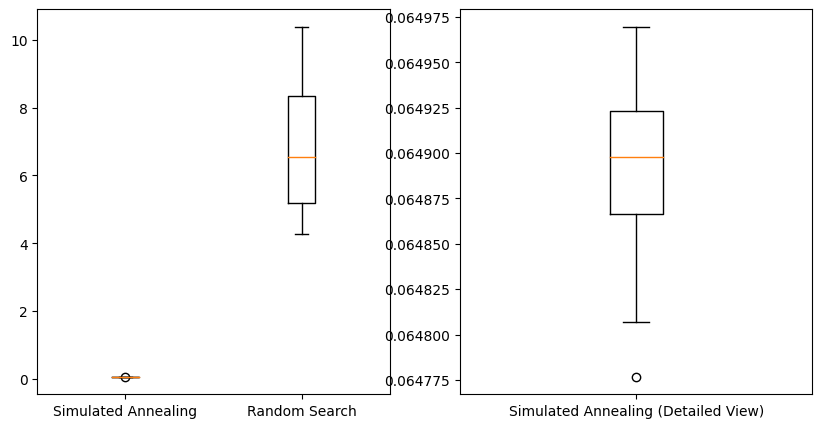

In [279]:
fig, axes = plt.subplots(ncols=2, sharey=False, figsize=(10, 5))
axes[0].boxplot(list([optimiser_results_annealing, optimiser_results_random]), labels=["Simulated Annealing", "Random Search"])
axes[1].boxplot(optimiser_results_annealing, labels=["Simulated Annealing (Detailed View)"])
fig.show()

## Statistical Evaluation

In [280]:
# This array stores the difference in objective scores between the random, simulated annealing methods across all 21 tests
objective_delta = np.subtract(
    optimiser_results_random, optimiser_results_annealing
)

annealing_mean = np.mean(optimiser_results_annealing)
random_mean = np.mean(optimiser_results_random)
delta_mean = np.mean(objective_delta)
print("Statistical Results:\n")
print(
    "Simulated Annealing Mean Objective = {}\nRandom Search Mean Objective = {}\nMean Improvement of Simulated Annealing over Random Search = {}"
    .format(annealing_mean, random_mean, delta_mean)
)
print("Simulated Annealing as a percentage of Random Search: {}%\n".format((annealing_mean/random_mean) * 100))

print(
    "Simulated Annealing Variance: {}\nRandom Search Variance: {}"
    .format(np.var(optimiser_results_annealing), np.var(optimiser_results_random))
    )

Statistical Results:

Simulated Annealing Mean Objective = 0.06489121630834757
Random Search Mean Objective = 6.9023079711516315
Mean Improvement of Simulated Annealing over Random Search = 6.837416754843283
Simulated Annealing as a percentage of Random Search: 0.9401379448665872%

Simulated Annealing Variance: 2.3518511448373526e-09
Random Search Variance: 3.176471294145885


These results clearly show that Simulated Annealing is a significantly better optimisation approach for this problem than Random Search is, especially at a relatively low number of samples. 

Simulated Annealing produces much better results for minimising the objective function, with an average objective function value less than 1% of that of Random Search. <br>
Additionally, Simulated Annealing produces much more consistent result regardless of the input seed than Random Search does at the same number of samples, with a variance nine orders of magnitude lower than the variance for random search.

It is worth considering that a Random Search algorithm may be able to execute with a higher samples value within the same time as a Simulated Annealing function with a lower sample number, however, overall Simulated Annealing appears to deliver a much more optimal and reliable solution to the problem situation. 

## Some comments on Hyper-parameters


Decay:<br>
I chose to test with fast and logarithmic decay functions. 
I found that fast decay typically generated superior results, at least with the relatively low sample numbers that I chose to use. 

Step Size:<br>
I found that lower step sizes yielded better significantly results, with higher step values causing the simulated annealing to get stuck at much less optimal solutions.

Initial Temperature:<br>
I didn't find that changing initial temperature had a significant effect on the results.

Samples:<br>
Generally I found that changing the number of samples used has a much greater effect on random search than on simulated annealing. This is to be expected, since simulated annealing tends towards more subtle, incremental improvements over time, causing improvement to slow, while random search still has a chance of significant improvement.